# Quadrupolar pick-up: online spectrograms

This notebook contains snippets used for evaluating the spectrograms of quadrupolar pick-up data at CERN's Proton Synchrotron machine. Machine development sessions took place based on this script from 2016 to 2018.

Find device info under http://wwwpsco.cern.ch

For the quadrupolar pick-up, named `PR.BQL72` in the system, currently the following fields are available to japc and thus here in python:
https://apex-sso.cern.ch/pls/htmldb_dbabco/f?p=CONFIG_BROWSER:12:110156392625052:GO:NO:RP,2:P12_DEVICE_NAME,P12_IMPLEMENTATION:PR.BQL72,FESA%203

2018, Adrian Oeftiger

## General Set-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

from scipy.constants import c, m_p, e, epsilon_0

In [2]:
# path for my japc installation
import sys
sys.path.append('/afs/cern.ch/work/o/oeftiger/private/git/')

In [4]:
# from SPSMeasurementTools.timestamp_helpers import unixstamp2datestring
import time
def unixstamp2datestring(t_stamp):
    '''Taken from SPSMeasurementTools'''
    return time.strftime("%Y_%m_%d", time.localtime(t_stamp))
import pytz

In [5]:
import pyjapc

In [9]:
plt.ion()

In [10]:
R = 100
gamma = 2.49
beta = np.sqrt(1 - gamma**-2)

## Set-up for this MD

In [6]:
# choose the timing user
japc = pyjapc.PyJapc(selector='CPS.USER.MD8')

In [ ]:
!mkdir save_qpu

In [12]:
class Container(object):
    '''Container object for the online japc subscription.
    Contains the mechanism to update the values as well as
    the plotting machinery. 
    Stores the data in subdirectory save_qpu
    (make sure it has been created!).
    '''
    def __init__(self, zoom_l=200, zoom_u=1400, window_length=128, window_step=1):
        self.fig = plt.figure(figsize=(9,10))
        
        self._newValue = None
        self.zoom_l = zoom_l
        self.zoom_u = zoom_u
        self.window_length = window_length
        self.window_step = window_step
        self.field = 'rawDataH'
    @property
    def newValue(self):
        return self._newValue
    @newValue.setter
    def newValue(self, newValue):
        self._newValue = newValue
        
        qpu_data = self._newValue[self.field]
        
        qpu_data = qpu_data[self.zoom_l:self.zoom_u]
        self.update(qpu_data)
        self.save(qpu_data)
    def save(self, qpu_data):
        np.save('./save_qpu/{:d}'.format(int(time.time() * 1e6)) + '.npy', qpu_data)
    def update(self, qpu_data):
        plt.figure(self.fig.number)
        plt.clf()
        self.ax_main = plt.subplot2grid((6, 1), (0, 0), rowspan=5)
        self.ax_cbar = plt.subplot2grid((6, 1), (5, 0))
        
        window_length = self.window_length
        window_step = self.window_step

        spec = []

        for window_start in np.arange(0, len(qpu_data)-window_length, window_step):
            spec.append(np.abs(np.fft.rfft(qpu_data[window_start:window_start+window_length])))

        plt.sca(self.ax_main)
        to_be_plotted = np.log(np.array(spec)[:, 1:-1])
    
        xliml, xlimu = np.fft.rfftfreq(window_length)[[1,-2]]
        yliml = 0
        ylimu = len(qpu_data) - window_length
        
#         plt.imshow(np.log(np.array(spec)), origin='lower', 
#                    extent=[0, 0.5, 0, len(qpu_data)-window_length],
#                    interpolation='none')
        
        plot = plt.imshow(
                   to_be_plotted, origin='lower', 
                   extent=[xliml, xlimu, 
                           yliml, ylimu],
                   interpolation='none', 
#                    vmin=to_be_plotted.min() + 5,#8,
#     #                vmax=26
        )
    
        plt.gca().set_aspect(np.diff(plt.xlim()) / np.diff(plt.ylim()))
        plt.ylabel('turn start')
#         plt.xlabel('frequency')
        plt.xlabel('fractional tune $f/f_{rev}$')
        plt.xlim(0, 0.5)
        
        plt.title(str(self.header['cycleStamp'].astimezone(pytz.timezone('CET'))))

        # plt.axvline(Qx%1, color='black', ls='--')
        # plt.axvline(Qy%1, color='black', ls='--')
        # plt.axvline((Qx+Qy)%1, color='black', ls='--')
        # plt.axvline((2*Qx)%1, color='black', ls='--')
        # plt.axvline((2*Qy)%1, color='black', ls='--')

        # plt.axvline(Qp(a, b, Qx, Qy, Ksc)%1, color='red', ls='-.')
        # plt.axvline(Qm(a, b, Qx, Qy, Ksc)%1, color='red', ls='-.')

        plt.gca().tick_params('both', which='major', size=6, direction='out')
    
        ca = plt.gca()
        yliml, ylimu = plt.ylim()
        plt.twinx()
        plt.cla()
        C = 2*np.pi*R
        v = beta*c
        ts = C/v
        
        extent_lower = yliml*ts*1e3 - (self.zoom_l - 2*window_length
                                      )*ts*1e3
        extent_upper = ylimu*ts*1e3 - (self.zoom_l - 2*window_length
                                      )*ts*1e3
        
        plt.ylim((extent_lower, extent_upper))
        plt.ylabel('time after C170 [ms]')
        plt.sca(ca)

        plt.sca(self.ax_cbar)
        plt.colorbar(plot, cax=self.ax_cbar, orientation='horizontal', label='log of spectrum')
        
        # plt.title(r"$N = {:.3f}\times 10^{{12}}$".format(N*1e-12), y=1.04, fontsize=18)
        # plt.suptitle(files[idx], fontsize=20)
        plt.subplots_adjust(top=0.85, hspace=2)
        plt.show(block=False)

# Online Spectrogram

<IPython.core.display.Javascript object>


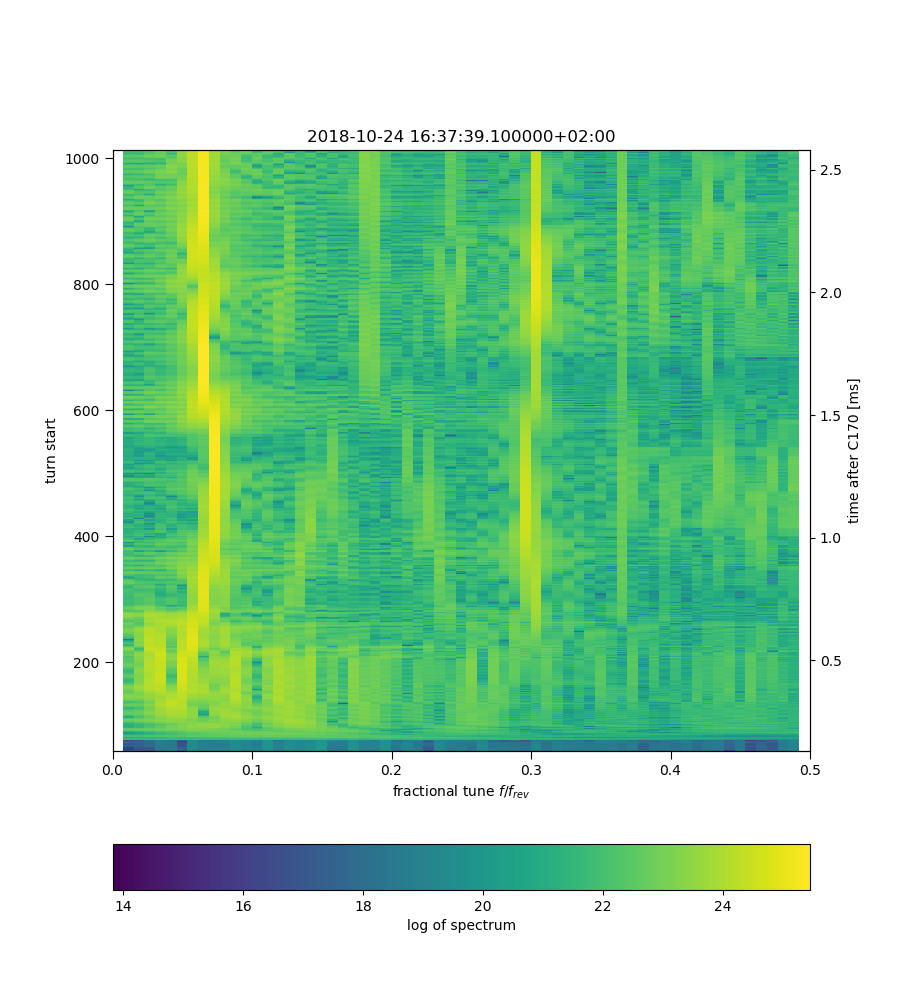

In [13]:
cont = Container()

# Setting up the call back and parameters with japc

In [16]:
def myCallBack(paramName, newValue, header):
    cont.header = header
    cont.newValue = newValue

In [17]:
japc.subscribeParam("PR.BQL72_Q/Acquisition", onValueReceived=myCallBack, getHeader=True)

# Run this to start online subscription and observe most recent shot as spectrogram above

In [18]:
japc.startSubscriptions()